# Employee Performance With Resign Prediction Using ML (2)

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')

In [41]:
# !pip install --upgrade scikit-learn
# !pip install catboost
# !pip install lightgbm

In [7]:
from imblearn.over_sampling import SMOTE

In [42]:
import xgboost  as xgb
import lightgbm as lgb
import catboost as cat

In [8]:
# library dibawah sebenarnya udah ada di pyforest
from sklearn.model_selection       import train_test_split
from sklearn.feature_selection     import SelectKBest, f_classif
from sklearn.preprocessing         import MinMaxScaler, StandardScaler
from sklearn.preprocessing         import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline              import make_pipeline
from sklearn.compose               import ColumnTransformer
from sklearn.metrics               import (f1_score,
                                           precision_score,
                                           recall_score,
                                           log_loss,
                                           accuracy_score,
                                           classification_report,
                                           ConfusionMatrixDisplay,
                                           confusion_matrix)


from pyspark.sql                   import SparkSession
from sklearn.ensemble              import StackingClassifier
from sklearn.pipeline              import Pipeline
from sklearn.preprocessing         import StandardScaler
from sklearn_pandas                import DataFrameMapper
from sklearn.ensemble              import AdaBoostClassifier
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.linear_model          import LogisticRegression
from matplotlib.colors             import ListedColormap
from sklearn.linear_model          import SGDClassifier
from sklearn.ensemble              import RandomForestClassifier
from sklearn.linear_model          import SGDClassifier
from sklearn.svm                   import SVC
from sklearn.naive_bayes           import GaussianNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.neighbors             import NeighborhoodComponentsAnalysis
from keras.callbacks               import EarlyStopping

In [9]:
# env
os.environ['HADOOP_HOME'] = r"C:\hadoop"
os.environ['HADOOP_CONF_DIR'] = r"C:\hadoop\etc\hadoop"
os.environ['JAVA_HOME'] = r"C:\Java"  # path jdk

# sesi spark
spark = SparkSession.builder \
    .appName("Hadoop Clustering Performa Karyawan") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.yarn.stagingDir", "/user/ASUS/.sparkStaging") \
    .getOrCreate()

In [10]:
# data hdfs
hdfs_path = "/user/ASUS/hadoop_clustering_employee_turnover/cluster.csv"
data_hadoop = spark.read.csv(hdfs_path, header=True, inferSchema=True)

<IPython.core.display.Javascript object>

In [12]:
df = pd.DataFrame(data_hadoop)

<IPython.core.display.Javascript object>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tingkat_kepuasan            14999 non-null  float64
 1   evaluasi_terakhir           14999 non-null  float64
 2   jumlah_proyek               14999 non-null  int64  
 3   rata-rata_jam_bulan         14999 non-null  int64  
 4   waktu_spent_for_perusahaan  14999 non-null  int64  
 5   Kecelakaan_kerja            14999 non-null  int64  
 6   resign                      14999 non-null  int64  
 7   promosi_5tahun_terakhir     14999 non-null  int64  
 8   gaji                        14999 non-null  int64  
 9   IT                          14999 non-null  int64  
 10  RandD                       14999 non-null  int64  
 11  accounting                  14999 non-null  int64  
 12  hr                          14999 non-null  int64  
 13  management                  149

In [14]:
df.columns

Index(['tingkat_kepuasan', 'evaluasi_terakhir', 'jumlah_proyek',
       'rata-rata_jam_bulan', 'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'resign', 'promosi_5tahun_terakhir', 'gaji', 'IT', 'RandD',
       'accounting', 'hr', 'management', 'marketing', 'product_mng', 'sales',
       'support', 'technical', 'cluster'],
      dtype='object')

In [15]:
df

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,resign,promosi_5tahun_terakhir,gaji,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,cluster
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,3
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,3
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2
14995,0.37,0.48,2,160,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2
14996,0.37,0.53,2,143,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,4
14997,0.11,0.96,6,280,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,3


### Feature Selection

h0 = tidak ada hubungan antara fitur independen dengan variabel target (resign) dengan mengunakan KBest

coba lebih kecil dulu dibanding alpha / p-value 0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

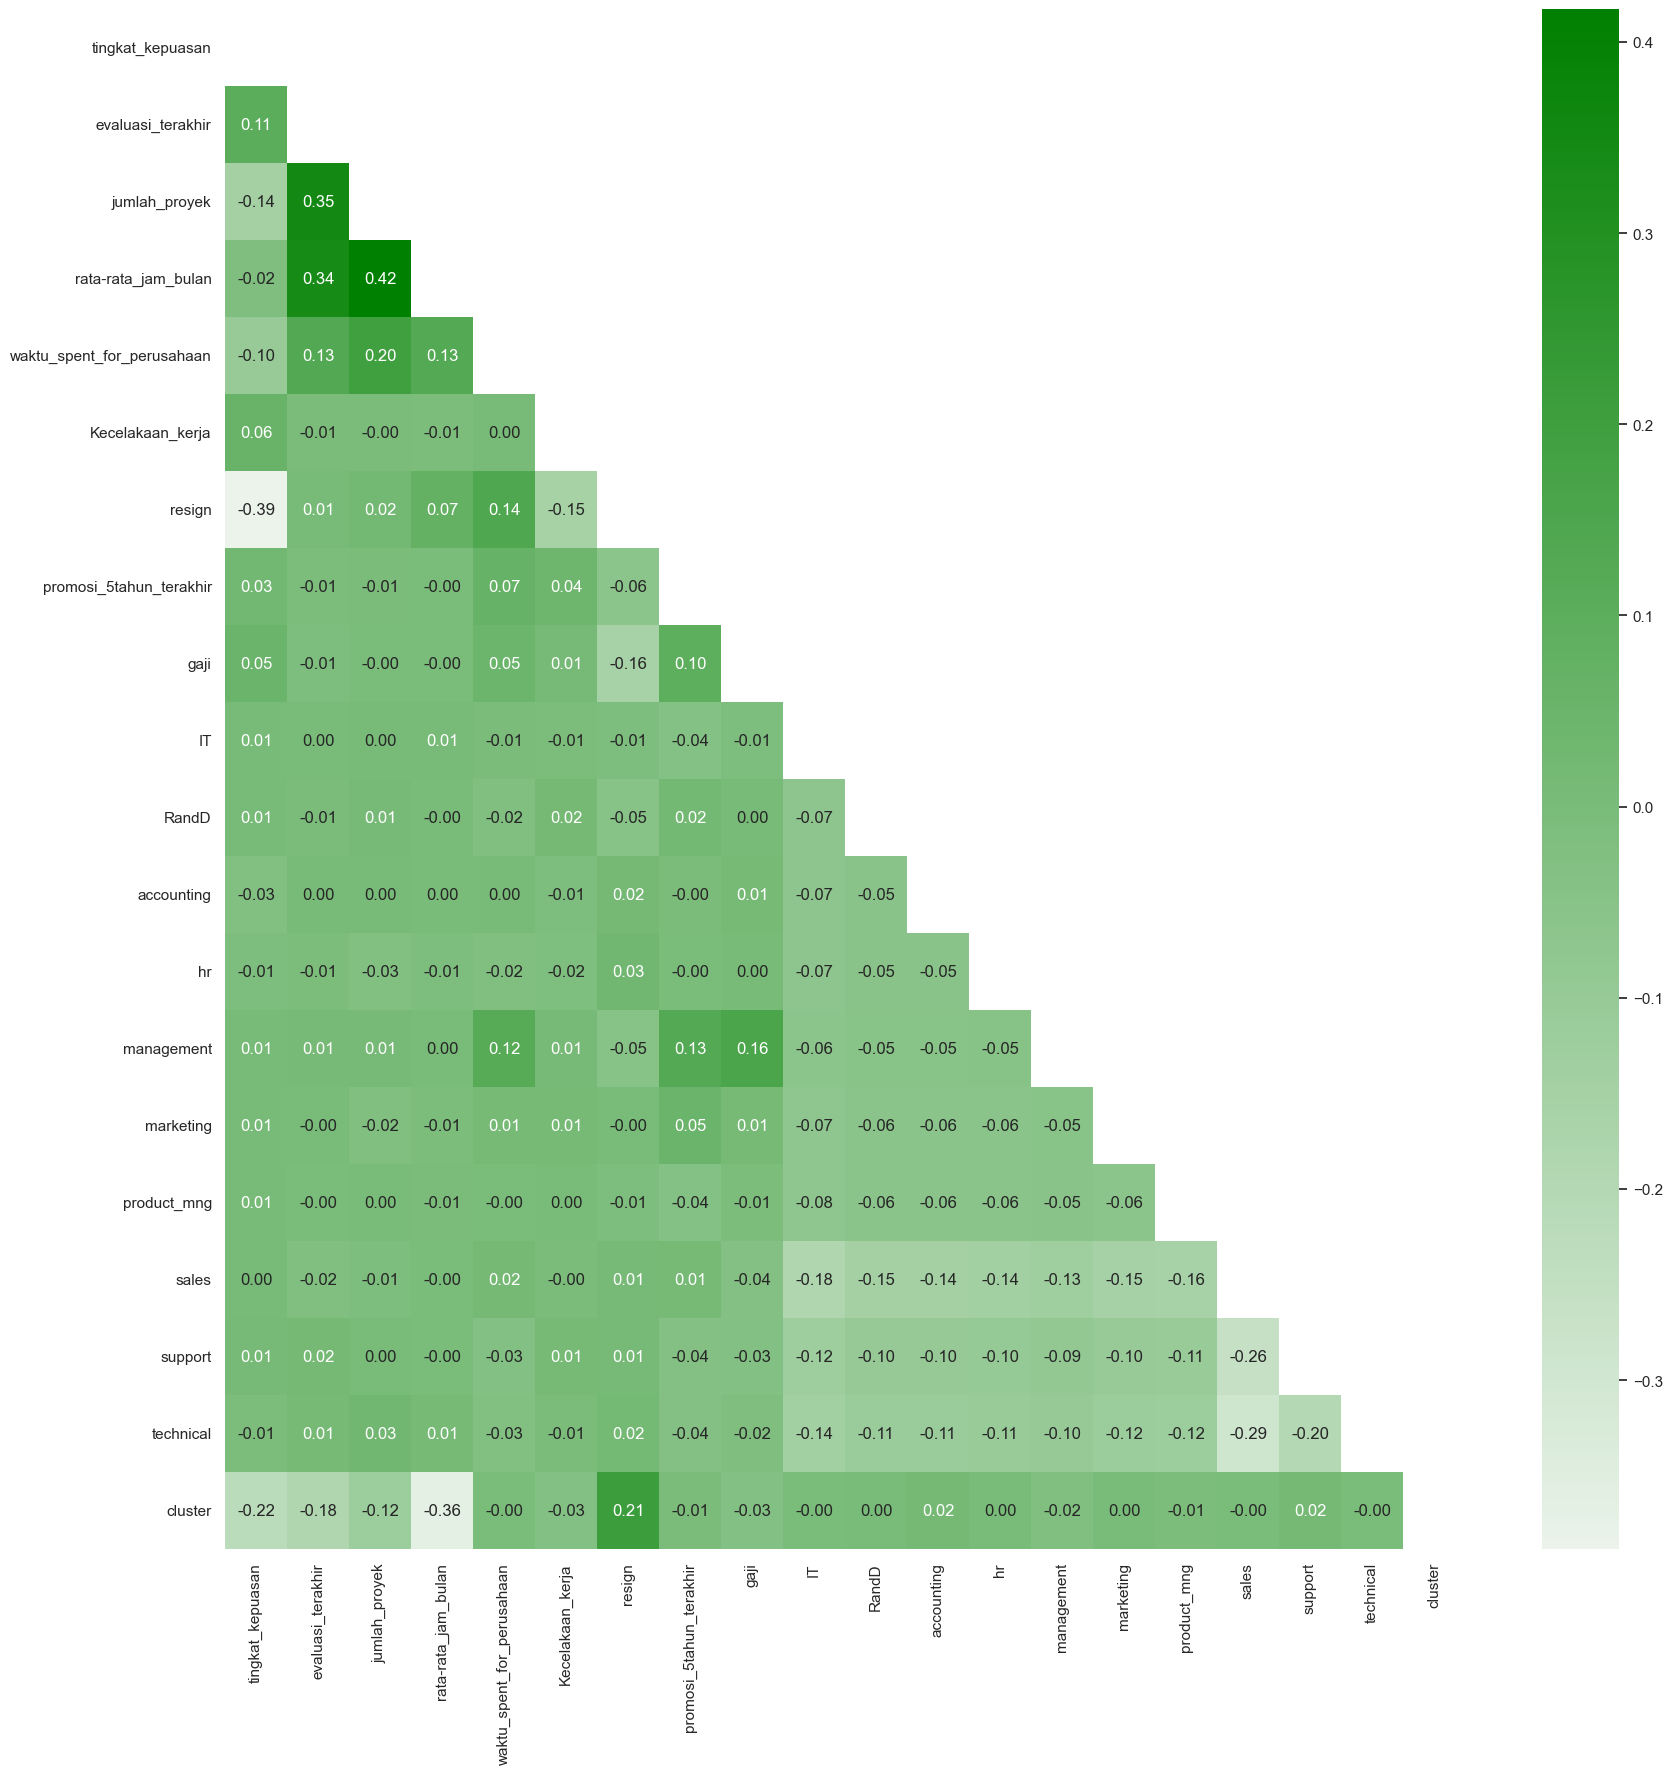

In [16]:
# viz
sns.set(font_scale=1)
plt.figure(figsize=(20, 20))
sns.set_style("white")
cmap = sns.light_palette("green", as_cmap=True)

mask = np.triu(np.ones_like(df.corr(), dtype=bool))

sns.heatmap(df.corr(),
            annot=True,
            cmap=cmap,
            fmt='.2f',
            mask=mask)

plt.show()

- waktu_spent_for_perusahaan
- jumlah_proyek
- rata-rata_jam_bulan
- evaluasi_terakhir ???
- kecelakaan kerja

In [17]:
X = df.drop('resign', axis=1)
y = pd.DataFrame(df['resign'])

<IPython.core.display.Javascript object>

In [18]:
X

,tingkat_kepuasan,evaluasi_terakhir,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,promosi_5tahun_terakhir,gaji,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,cluster
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0,2
1,0.80,0.86,5,262,6,0,0,1,0,0,0,0,0,0,0,1,0,0,3
2,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0,3
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,0,0,0,0,0,0,0,0,0,1,0,2
14995,0.37,0.48,2,160,3,0,0,0,0,0,0,0,0,0,0,0,1,0,2
14996,0.37,0.53,2,143,3,0,0,0,0,0,0,0,0,0,0,0,1,0,4
14997,0.11,0.96,6,280,4,0,0,0,0,0,0,0,0,0,0,0,1,0,3


In [19]:
y

,resign
0,1
1,1
2,1
3,1
4,1
...,...
14994,1
14995,1
14996,1
14997,1


In [20]:
corr = X.corr()
data_corr = X.copy()

In [21]:
selector  = SelectKBest(score_func=f_classif, k=10)
selector  = selector.fit(data_corr, y)

df_scores = pd.DataFrame({'Feature': data_corr.columns,
                         'Score': selector.scores_,
                         'p-value': (selector.pvalues_).round(4)})
    
df_scores = df_scores.sort_values(by=['Score'], ascending=False)
df_scores

<IPython.core.display.Javascript object>

,Feature,Score,p-value
0,tingkat_kepuasan,2663.881285,0.0000
18,cluster,719.120932,0.0000
7,gaji,383.461236,0.0000
5,Kecelakaan_kerja,367.328044,0.0000
4,waktu_spent_for_perusahaan,321.277313,0.0000
3,rata-rata_jam_bulan,76.601963,0.0000
6,promosi_5tahun_terakhir,57.474523,0.0000
9,RandD,32.631656,0.0000
12,management,31.849999,0.0000
11,hr,11.977040,0.0005


ingin memilih fitur-fitur yang memberikan bukti statistik yang cukup kuat untuk menolak hipotesis nol, dengan pernyataan bahwa tidak ada hubungan antara fitur independen dengan variabel target dengan mengunakan KBest.

maka dari itu aku bakal hapus variabel-variabel yang nilainya > 0.05

In [22]:
hapus = ['accounting',
        'product_mng',
        'IT',
        'support',
        'sales',
        'evaluasi_terakhir',
        'marketing']

In [23]:
X = X.drop(hapus, axis=1).sort_index()
X

,tingkat_kepuasan,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,promosi_5tahun_terakhir,gaji,RandD,hr,management,technical,cluster
0,0.38,2,157,3,0,0,0,0,0,0,0,2
1,0.80,5,262,6,0,0,1,0,0,0,0,3
2,0.11,7,272,4,0,0,1,0,0,0,0,3
3,0.72,5,223,5,0,0,0,0,0,0,0,0
4,0.37,2,159,3,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,2,151,3,0,0,0,0,0,0,0,2
14995,0.37,2,160,3,0,0,0,0,0,0,0,2
14996,0.37,2,143,3,0,0,0,0,0,0,0,4
14997,0.11,6,280,4,0,0,0,0,0,0,0,3


In [24]:
y.dtypes

resign    int64
dtype: object

### Imbalance Data

In [25]:
ccount = y['resign'].value_counts()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

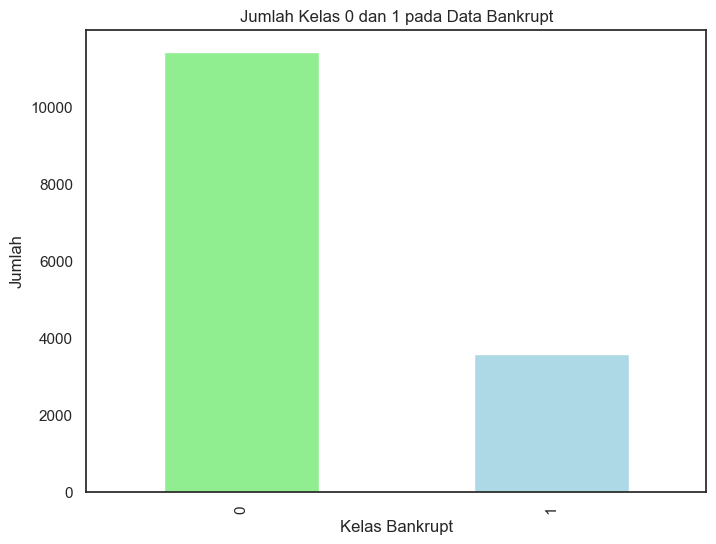

In [26]:
plt.figure(figsize=(8, 6))
ccount.plot(kind='bar', color=['lightgreen', 'lightblue'])
plt.title('Jumlah Kelas 0 dan 1 pada Data Bankrupt')
plt.xlabel('Kelas Bankrupt')
plt.ylabel('Jumlah')
plt.show()

In [27]:
ccount

resign
0    11428
1     3571
Name: count, dtype: int64

Data pada variabel target 'resign' tersebut merupakan imbalance data. Hal ini dikarenakan terdapat salah satu kelas yang memiliki kurang dari 30% dari total data.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [29]:
X_train.shape

(11249, 12)

In [30]:
balance = SMOTE(sampling_strategy='auto', random_state=42)

X_train_balance, y_train_balance = balance.fit_resample(X_train, y_train)

In [31]:
print(y_train_balance.value_counts(normalize=True))

resign
0         0.5
1         0.5
Name: proportion, dtype: float64


In [32]:
print(y_train.value_counts(normalize=True))

resign
0         0.76229
1         0.23771
Name: proportion, dtype: float64


In [33]:
X_train_balance.shape

(17150, 12)

In [35]:
X_train_balance.columns

Index(['tingkat_kepuasan', 'jumlah_proyek', 'rata-rata_jam_bulan',
       'waktu_spent_for_perusahaan', 'Kecelakaan_kerja',
       'promosi_5tahun_terakhir', 'gaji', 'RandD', 'hr', 'management',
       'technical', 'cluster'],
      dtype='object')

### Modelling
1. Mempersiapkan beberapa fungsi untuk kebutuhan modeling atau evaluasi berulang kali

fungsi untuk evaluasi nanti, kasus klasifikasi. menggunakan X_train_balance dan y_train_balance

2. Evaluasi dengan klasifikasi:
- accuracy
- precision
- recall (sensitivity)
- Specificity
- ROC-AUC
- Precision-Recall Curve and AUC
- F-beta score
- Matthews Correlation Coefficient
- Log loss

In [34]:
# y_true itu y_test
def model_report(y_true, y_pred):

    acc                     = accuracy_score(y_true, y_pred)
    pre                     = precision_score(y_true, y_pred)
    rec                     = recall_score(y_true, y_pred)
    f1                      = f1_score(y_true, y_pred)
    loss                    = log_loss(y_true, y_pred)

    print("accuracy:   {:3f}\nprecision:  {:3f}\nrecall:     {:3f}\nf1-score:   {:3f}\nloss:       {:3f}".
          format(acc, pre, rec, f1, loss))

In [46]:
random_forest              = RandomForestClassifier(max_depth=15, criterion="gini", n_estimators=38)
logistic_regression        = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
decision_tree              = DecisionTreeClassifier(max_depth=10, criterion="entropy")
knn_auto                   = KNeighborsClassifier(n_neighbors=30, algorithm="auto")
catboost                   = cat.CatBoostClassifier(verbose=0)
lightgbm                   = lgb.LGBMClassifier()
ada_boost                  = AdaBoostClassifier()
xgboost                    = xgb.XGBClassifier()
sgd                        = SGDClassifier()
gaussian                   = GaussianNB()

In [47]:
models = {
    "Logistic Regression"  : logistic_regression,
    "KNN Auto"             : knn_auto,
    "Decision Tree"        : decision_tree,
    "Random Forest"        : random_forest,
    "Ada Boost"            : ada_boost,
    "XGBoost"              : xgboost,
    "LightGBM"             : lightgbm,
    "CatBoost"             : catboost,
    "Gaussian Naive"       : gaussian,
    "SGD"                  : sgd
}

keterangan:
- **RandomForestClassifier**  : Model ensemble yang menggunakan banyak pohon keputusan untuk meningkatkan akurasi prediksi dan mengurangi overfitting.
- **LogisticRegression**     : Model statistik yang memprediksi probabilitas dari hasil biner dengan menggunakan fungsi logit (fungsi default).
- **DecisionTreeClassifier**: Model pohon keputusan yang membagi data ke dalam kelompok berdasarkan fitur untuk membuat prediksi yang sederhana dan mudah diinterpretasikan.
- **KNeighborsClassifier**: Model non-parametrik yang memprediksi kelas dari sampel berdasarkan mayoritas tetangga terdekatnya dalam ruang fitur. (inferensi). KNN mungkin cocok dikarenakan jumlah data cukup sedang
- **CatBoostClassifier**: Algoritma boosting berbasis pohon yang dioptimalkan untuk menangani data kategori dan mencegah overfitting.
- **LGBMClassifier**: Algoritma boosting berbasis pohon yang sangat efisien dan cepat untuk menangani data dengan jumlah besar dan fitur yang banyak.
- **AdaBoostClassifier**: Algoritma boosting yang menggabungkan beberapa model keputusan sederhana untuk meningkatkan kinerja prediktif dengan memberikan bobot lebih pada kesalahan sebelumnya.
- **XGBClassifier**: Algoritma boosting yang kuat dan fleksibel, dirancang untuk kinerja tinggi dengan waktu komputasi yang cepat.
- **SGDClassifier**: Model yang mengoptimalkan fungsi loss linear menggunakan metode penurunan gradien stokastik, cocok untuk dataset besar.
- **GaussianNB**: Model Naive Bayes yang menggunakan distribusi normal untuk memprediksi probabilitas kelas berdasarkan fitur yang diberikan.

### Training data

In [48]:
def model_report_train(y_true_train, y_pred_train):

    acc_train      = accuracy_score(y_true_train, y_pred_train)
    pre_train      = precision_score(y_true_train, y_pred_train)
    rec_train      = recall_score(y_true_train, y_pred_train)
    f1_train       = f1_score(y_true_train, y_pred_train)
    loss_train     = log_loss(y_true_train, y_pred_train)

    print("Train Data Metrics:")
    print("accuracy:   {:3f}\nprecision:  {:3f}\nrecall:     {:3f}\nf1-score:   {:3f}\nloss:       {:3f}".
          format(acc_train, pre_train, rec_train, f1_train, loss_train))

print("*"*46, "Performa Model ML pada Data Train", "*"*46, "\n")

for nama_model, model in models.items():

    model.fit(X_train_balance, y_train_balance)
    y_pred_train_b    = model.predict(X_train_balance)

    print(f"{nama_model}: ")

    model_report_train(y_train_balance, y_pred_train_b)

    print("="*25 + "\n")

********************************************** Performa Model ML pada Data Train ********************************************** 

Logistic Regression: 
Train Data Metrics:
accuracy:   0.782274
precision:  0.773657
recall:     0.798017
f1-score:   0.785649
loss:       7.847639

KNN Auto: 
Train Data Metrics:
accuracy:   0.926472
precision:  0.904894
recall:     0.953120
f1-score:   0.928381
loss:       2.650207

Decision Tree: 
Train Data Metrics:
accuracy:   0.970496
precision:  0.985441
recall:     0.955102
f1-score:   0.970034
loss:       1.063445

Random Forest: 
Train Data Metrics:
accuracy:   0.990612
precision:  0.997517
recall:     0.983673
f1-score:   0.990547
loss:       0.338369

Ada Boost: 
Train Data Metrics:
accuracy:   0.940875
precision:  0.937103
recall:     0.945190
f1-score:   0.941129
loss:       2.131094

XGBoost: 
Train Data Metrics:
accuracy:   0.991429
precision:  0.994717
recall:     0.988105
f1-score:   0.991400
loss:       0.308946

[LightGBM] [Info] Number of

### Testing data

In [51]:
X_test

,tingkat_kepuasan,jumlah_proyek,rata-rata_jam_bulan,waktu_spent_for_perusahaan,Kecelakaan_kerja,promosi_5tahun_terakhir,gaji,RandD,hr,management,technical,cluster
6723,0.65,5,226,2,1,0,1,0,0,0,0,0
6473,0.88,3,166,2,0,0,0,0,0,0,0,2
4679,0.69,3,214,2,0,0,0,0,0,0,0,1
862,0.41,2,154,3,0,0,0,0,0,0,0,2
7286,0.87,5,254,2,1,0,0,0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
10371,0.99,6,219,6,0,0,0,0,0,0,0,0
12541,0.81,4,254,5,0,0,0,0,0,0,0,3
2656,0.67,3,177,3,1,0,0,0,0,0,0,2
6759,0.22,5,174,6,0,0,2,0,0,0,1,2


In [52]:
print("*"*50, "Performa Testing Model ML", "*"*50, "\n")

for nama_model, model in models.items():

    model.fit(X_train_balance, y_train_balance)
    y_pred = model.predict(X_test)

    print(f"{nama_modelma_model}: ")
    model_report(y_test, y_pred)

    print("="*25 + "\n")

************************************************** Performa Testing Model ML ************************************************** 

Logistic Regression: 
accuracy:   0.772000
precision:  0.515719
recall:     0.768116
f1-score:   0.617107
loss:       8.217953

KNN Auto: 
accuracy:   0.906133
precision:  0.737991
recall:     0.942029
f1-score:   0.827620
loss:       3.383298

Decision Tree: 
accuracy:   0.970933
precision:  0.941704
recall:     0.936455
f1-score:   0.939072
loss:       1.047669

Random Forest: 
accuracy:   0.983200
precision:  0.967489
recall:     0.962096
f1-score:   0.964785
loss:       0.605533

Ada Boost: 
accuracy:   0.931467
precision:  0.811284
recall:     0.929766
f1-score:   0.866494
loss:       2.470192

XGBoost: 
accuracy:   0.980000
precision:  0.953642
recall:     0.963211
f1-score:   0.958403
loss:       0.720873

[LightGBM] [Info] Number of positive: 8575, number of negative: 8575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

### Train n test without Balancing

In [53]:
print("*"*50, "Performa Testing Model ML", "*"*50, "\n")

for nama_model, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"{nama_model}: ")
    model_report(y_test, y_pred)

    print("="*25 + "\n")

************************************************** Performa Testing Model ML ************************************************** 

Logistic Regression: 
accuracy:   0.804800
precision:  0.648115
recall:     0.402453
f1-score:   0.496561
loss:       7.035721

KNN Auto: 
accuracy:   0.934133
precision:  0.829615
recall:     0.911929
f1-score:   0.868826
loss:       2.374075

Decision Tree: 
accuracy:   0.976533
precision:  0.967630
recall:     0.933110
f1-score:   0.950057
loss:       0.845824

Random Forest: 
accuracy:   0.984000
precision:  0.980482
recall:     0.952062
f1-score:   0.966063
loss:       0.576698

Ada Boost: 
accuracy:   0.951733
precision:  0.909611
recall:     0.886288
f1-score:   0.897798
loss:       1.739707

XGBoost: 
accuracy:   0.984267
precision:  0.976136
recall:     0.957637
f1-score:   0.966798
loss:       0.567087

[LightGBM] [Info] Number of positive: 2674, number of negative: 8575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

#### Model hasil evaluasi dengan menggunakan data hasil balancing memilki performa yang lebih baik dibandingkan model yang menggunakan bdata tanpa balancing.

### Evaluasi Model
- Logistic Regression: Model menunjukkan overfitting dengan akurasi tinggi dan presisi yang baik pada data train, namun terdapat penurunan yang signifikan pada data test, menunjukkan kemungkinan overfitting dan generalisasi yang buruk.
- KNN Auto: Model menunjukkan performa yang baik dengan hasil yang serupa di antara data train dan test, menunjukkan kemampuan generalisasi yang baik dan minim overfitting.
- Decision Tree: Model menunjukkan tanda-tanda overfitting dengan hasil yang hampir sempurna pada data train, namun memiliki performa yang baik pada data test, menunjukkan kemungkinan overfitting namun kemampuan generalisasi yang baik.
- Random Forest: Model cenderung overfitting dengan performa yang sangat baik pada data train, namun masih memiliki performa yang baik pada data test.
- Ada Boost: Model menunjukkan performa yang baik pada data train dengan performa yang cukup baik pada data test, namun terdapat penurunan yang signifikan dari data train, menunjukkan kemungkinan overfitting namun kemampuan generalisasi yang baik.
- XGBoost: Model menunjukkan performa yang sangat baik pada data train dengan performa yang baik pada data test, namun ada sedikit penurunan dari data train.
- LightGBM: Model menunjukkan performa yang baik pada data train dengan sedikit tanda overfitting, namun masih memiliki performa yang sangat baik pada data test.
- CatBoost: Model menunjukkan performa yang baik pada data train dengan performa yang baik pada data test, menunjukkan kemampuan generalisasi yang baik dan minim overfitting.
- Gaussian Naive: Model menunjukkan tanda-tanda underfitting dengan performa yang rendah pada data train, dan performa yang buruk pada data test, menunjukkan generalisasi yang buruk.
- SGD: Model menunjukkan tanda-tanda underfitting dengan performa yang rendah pada data train, namun masih memiliki performa yang cukup baik pada data test, menunjukkan kemampuan generalisasi yang rendah dari data train.

### Top 3 Model

1. **KNN Auto**:
- accuracy:   0.906133
- precision:  0.737991
- recall:     0.942029
- f1-score:   0.827620
- loss:       3.383298

=========================

2. **LightGBM**:
- accuracy:   0.979200
- precision:  0.962712
- recall:     0.949833
- f1-score:   0.956229
- loss:       0.749708

=========================

3. **CatBoost**:
- accuracy:   0.976533
- precision:  0.949944
- recall:     0.952062
- f1-score:   0.951002
- loss:       0.845824

=========================

Ketiga model ini memiliki kemampuan generalisasi yang baik tanpa menunjukkan tanda-tanda overfitting. Evaluasi pada data test menunjukkan bahwa ketiganya memiliki performa yang konsisten dan dapat diandalkan dalam memprediksi target yang sesuai.

### Hyperparameter on KNN

In [54]:
# Fungsi Evaluasi Suatu Model dengan Confusion Matrix
def plot_confusion_matriks(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tampil = ConfusionMatrixDisplay(confusion_matrix=cm)

    tampil.plot(cmap='Greys')

    plt.title('Confusion Matrix')
    plt.show()

In [55]:
knn_auto_cv = KNeighborsClassifier()

parameter_knn = {
    'n_neighbors': [5, 10, 15, 20, 25, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_cv_knn = GridSearchCV(estimator=knn_auto_cv,
                           param_grid=parameter_knn,
                           cv=5,
                           scoring='accuracy')

<IPython.core.display.Javascript object>

In [56]:
grid_cv_knn.fit(X_train_balance, y_train_balance)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [5, 10, 15, 20, 25, 30]},
             scoring='accuracy')

In [57]:
print('Tuning Hiperparameter KNN: ', grid_cv_knn.best_params_)

Tuning Hiperparameter KNN:  {'algorithm': 'brute', 'n_neighbors': 5}


algoritma 'brute' itu akan memeriksa semua data point pelatihan dan menghitung jarak antara titik tersebut dan titik yang sedang diprediksi.

In [58]:
knn_best = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

knn_best.fit(X_train_balance, y_train_balance)

KNeighborsClassifier(algorithm='brute')

In [59]:
y_tt_knn_best = knn_best.predict(X_test)
y_tt_knn_best

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
print('Klasifikasi Report dari Best KNN:')
print(classification_report(y_test, y_tt_knn_best))

Klasifikasi Report dari Best KNN:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2853
           1       0.78      0.96      0.86       897

    accuracy                           0.92      3750
   macro avg       0.88      0.94      0.90      3750
weighted avg       0.94      0.92      0.93      3750



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

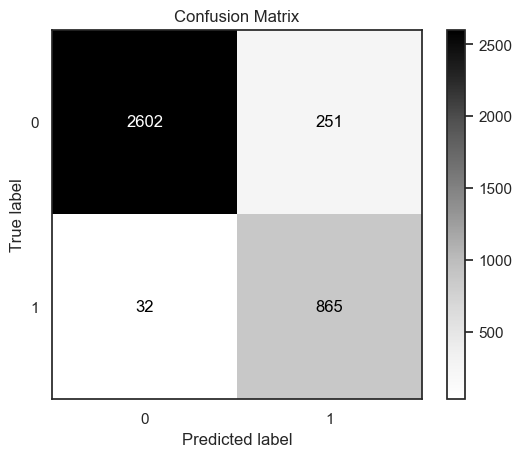

In [61]:
plot_confusion_matriks(y_test, y_tt_knn_best)

### Hyperparameter on Cat Boost

In [62]:
cat_cv = cat.CatBoostClassifier(verbose=0)

#parameter cukup banyak untuk dicoba, jadi pake randomized
parameter_cat = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

grid_cv_cat = RandomizedSearchCV(cat_cv,
                                 param_distributions=parameter_cat,
                                 n_iter=10,
                                 scoring='accuracy',
                                 cv=5,
                                 verbose=2,
                                 random_state=42,
                                 n_jobs=-1)

grid_cv_cat.fit(X_train_balance, y_train_balance)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001A6301F6350>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ])},
                   random_state=42, scoring='accuracy', verbose=2)

In [63]:
grid_cv_cat.best_params_

{'learning_rate': 0.3, 'l2_leaf_reg': 3, 'depth': 6}

In [64]:
cat_best = cat.CatBoostClassifier(learning_rate=0.3,
                                  l2_leaf_reg=3,
                                  depth=6)

cat_best.fit(X_train_balance, y_train_balance)

0:	learn: 0.3630619	total: 29.7ms	remaining: 29.7s
1:	learn: 0.2529685	total: 36.6ms	remaining: 18.3s
2:	learn: 0.2060985	total: 42.8ms	remaining: 14.2s
3:	learn: 0.1820613	total: 49.4ms	remaining: 12.3s
4:	learn: 0.1671145	total: 55.9ms	remaining: 11.1s
5:	learn: 0.1521644	total: 62.6ms	remaining: 10.4s
6:	learn: 0.1432193	total: 68.5ms	remaining: 9.72s
7:	learn: 0.1368760	total: 74.8ms	remaining: 9.27s
8:	learn: 0.1315763	total: 80.6ms	remaining: 8.88s
9:	learn: 0.1278103	total: 86.4ms	remaining: 8.55s
10:	learn: 0.1252297	total: 92.4ms	remaining: 8.31s
11:	learn: 0.1217555	total: 98.2ms	remaining: 8.08s
12:	learn: 0.1192543	total: 104ms	remaining: 7.88s
13:	learn: 0.1162454	total: 111ms	remaining: 7.8s
14:	learn: 0.1151675	total: 117ms	remaining: 7.67s
15:	learn: 0.1116106	total: 123ms	remaining: 7.54s
16:	learn: 0.1102074	total: 129ms	remaining: 7.44s
17:	learn: 0.1082233	total: 135ms	remaining: 7.35s
18:	learn: 0.1069716	total: 141ms	remaining: 7.26s
19:	learn: 0.1055865	total: 14

163:	learn: 0.0336350	total: 1.42s	remaining: 7.25s
164:	learn: 0.0334274	total: 1.43s	remaining: 7.24s
165:	learn: 0.0332267	total: 1.44s	remaining: 7.23s
166:	learn: 0.0329584	total: 1.45s	remaining: 7.23s
167:	learn: 0.0326681	total: 1.46s	remaining: 7.21s
168:	learn: 0.0323749	total: 1.46s	remaining: 7.19s
169:	learn: 0.0322257	total: 1.47s	remaining: 7.17s
170:	learn: 0.0320816	total: 1.47s	remaining: 7.14s
171:	learn: 0.0318311	total: 1.48s	remaining: 7.12s
172:	learn: 0.0317016	total: 1.49s	remaining: 7.11s
173:	learn: 0.0315521	total: 1.49s	remaining: 7.09s
174:	learn: 0.0314079	total: 1.5s	remaining: 7.07s
175:	learn: 0.0313034	total: 1.5s	remaining: 7.05s
176:	learn: 0.0312332	total: 1.51s	remaining: 7.03s
177:	learn: 0.0311515	total: 1.52s	remaining: 7s
178:	learn: 0.0310692	total: 1.52s	remaining: 6.98s
179:	learn: 0.0308232	total: 1.53s	remaining: 6.97s
180:	learn: 0.0307889	total: 1.53s	remaining: 6.95s
181:	learn: 0.0305421	total: 1.54s	remaining: 6.93s
182:	learn: 0.030

342:	learn: 0.0187632	total: 2.63s	remaining: 5.04s
343:	learn: 0.0187632	total: 2.63s	remaining: 5.03s
344:	learn: 0.0187035	total: 2.64s	remaining: 5.02s
345:	learn: 0.0187034	total: 2.65s	remaining: 5.01s
346:	learn: 0.0187034	total: 2.69s	remaining: 5.06s
347:	learn: 0.0187033	total: 2.71s	remaining: 5.07s
348:	learn: 0.0187033	total: 2.71s	remaining: 5.06s
349:	learn: 0.0187032	total: 2.72s	remaining: 5.04s
350:	learn: 0.0187031	total: 2.72s	remaining: 5.03s
351:	learn: 0.0187031	total: 2.73s	remaining: 5.02s
352:	learn: 0.0187030	total: 2.73s	remaining: 5.01s
353:	learn: 0.0187030	total: 2.74s	remaining: 5s
354:	learn: 0.0186626	total: 2.75s	remaining: 4.99s
355:	learn: 0.0186626	total: 2.75s	remaining: 4.98s
356:	learn: 0.0186625	total: 2.76s	remaining: 4.97s
357:	learn: 0.0186625	total: 2.76s	remaining: 4.96s
358:	learn: 0.0186624	total: 2.77s	remaining: 4.94s
359:	learn: 0.0186623	total: 2.77s	remaining: 4.93s
360:	learn: 0.0186622	total: 2.78s	remaining: 4.92s
361:	learn: 0.0

505:	learn: 0.0183990	total: 3.63s	remaining: 3.54s
506:	learn: 0.0183183	total: 3.64s	remaining: 3.54s
507:	learn: 0.0181721	total: 3.67s	remaining: 3.55s
508:	learn: 0.0181576	total: 3.71s	remaining: 3.58s
509:	learn: 0.0181060	total: 3.73s	remaining: 3.58s
510:	learn: 0.0180747	total: 3.75s	remaining: 3.59s
511:	learn: 0.0180278	total: 3.76s	remaining: 3.59s
512:	learn: 0.0179659	total: 3.78s	remaining: 3.59s
513:	learn: 0.0179291	total: 3.8s	remaining: 3.59s
514:	learn: 0.0178235	total: 3.81s	remaining: 3.59s
515:	learn: 0.0177566	total: 3.83s	remaining: 3.59s
516:	learn: 0.0177107	total: 3.84s	remaining: 3.59s
517:	learn: 0.0176598	total: 3.85s	remaining: 3.58s
518:	learn: 0.0175873	total: 3.86s	remaining: 3.57s
519:	learn: 0.0175544	total: 3.87s	remaining: 3.57s
520:	learn: 0.0175108	total: 3.88s	remaining: 3.56s
521:	learn: 0.0174675	total: 3.89s	remaining: 3.56s
522:	learn: 0.0174673	total: 3.89s	remaining: 3.55s
523:	learn: 0.0174312	total: 3.9s	remaining: 3.54s
524:	learn: 0.

686:	learn: 0.0145520	total: 5.01s	remaining: 2.28s
687:	learn: 0.0145519	total: 5.03s	remaining: 2.28s
688:	learn: 0.0145519	total: 5.04s	remaining: 2.28s
689:	learn: 0.0145519	total: 5.05s	remaining: 2.27s
690:	learn: 0.0145518	total: 5.06s	remaining: 2.26s
691:	learn: 0.0145518	total: 5.07s	remaining: 2.25s
692:	learn: 0.0145518	total: 5.07s	remaining: 2.25s
693:	learn: 0.0145518	total: 5.08s	remaining: 2.24s
694:	learn: 0.0145517	total: 5.08s	remaining: 2.23s
695:	learn: 0.0145517	total: 5.09s	remaining: 2.22s
696:	learn: 0.0145517	total: 5.09s	remaining: 2.21s
697:	learn: 0.0145516	total: 5.1s	remaining: 2.21s
698:	learn: 0.0145516	total: 5.11s	remaining: 2.2s
699:	learn: 0.0145516	total: 5.11s	remaining: 2.19s
700:	learn: 0.0145008	total: 5.12s	remaining: 2.18s
701:	learn: 0.0145007	total: 5.12s	remaining: 2.17s
702:	learn: 0.0145007	total: 5.13s	remaining: 2.17s
703:	learn: 0.0145007	total: 5.14s	remaining: 2.16s
704:	learn: 0.0145006	total: 5.14s	remaining: 2.15s
705:	learn: 0.

859:	learn: 0.0134685	total: 6.4s	remaining: 1.04s
860:	learn: 0.0134683	total: 6.41s	remaining: 1.03s
861:	learn: 0.0134683	total: 6.42s	remaining: 1.03s
862:	learn: 0.0134683	total: 6.43s	remaining: 1.02s
863:	learn: 0.0134682	total: 6.44s	remaining: 1.01s
864:	learn: 0.0134681	total: 6.45s	remaining: 1.01s
865:	learn: 0.0134680	total: 6.45s	remaining: 999ms
866:	learn: 0.0134680	total: 6.46s	remaining: 992ms
867:	learn: 0.0134679	total: 6.47s	remaining: 984ms
868:	learn: 0.0134678	total: 6.48s	remaining: 977ms
869:	learn: 0.0134677	total: 6.49s	remaining: 969ms
870:	learn: 0.0134676	total: 6.5s	remaining: 963ms
871:	learn: 0.0134676	total: 6.51s	remaining: 956ms
872:	learn: 0.0134675	total: 6.52s	remaining: 948ms
873:	learn: 0.0134674	total: 6.53s	remaining: 942ms
874:	learn: 0.0134674	total: 6.54s	remaining: 934ms
875:	learn: 0.0134385	total: 6.55s	remaining: 927ms
876:	learn: 0.0134385	total: 6.56s	remaining: 920ms
877:	learn: 0.0134385	total: 6.57s	remaining: 913ms
878:	learn: 0.

In [65]:
y_tt_cat_best = cat_best.predict(X_test)
y_tt_cat_best

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [66]:
print('Klasifikasi Report dari Best CatBoost:')
print(classification_report(y_test, y_tt_cat_best))

Klasifikasi Report dari Best CatBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2853
           1       0.95      0.97      0.96       897

    accuracy                           0.98      3750
   macro avg       0.97      0.98      0.97      3750
weighted avg       0.98      0.98      0.98      3750



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

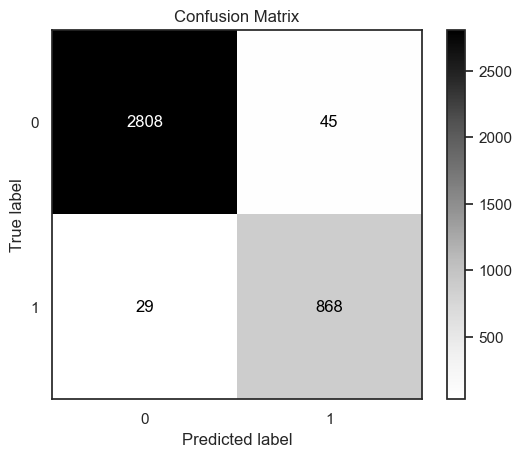

In [67]:
plot_confusion_matriks(y_test, y_tt_cat_best)

### Hyperparameter on Light GBM

In [68]:
lgbm_cv = lgb.LGBMClassifier()

parameter_lgbm = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7, 9]
}

grid_cv_lgbm = RandomizedSearchCV(lgbm_cv,
                                 param_distributions=parameter_lgbm,
                                 n_iter=30,
                                 scoring='accuracy',
                                 cv=5,
                                 verbose=2,
                                 random_state=42,
                                 n_jobs=-1)

grid_cv_lgbm.fit(X_train_balance, y_train_balance)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8575, number of negative: 8575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 17150, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': [4, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   random_state=42, scoring='accuracy', verbose=2)

In [69]:
grid_cv_lgbm.best_params_

{'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2677777777777778}

In [70]:
lgbm_best = lgb.LGBMClassifier(min_child_weight=1, 
                               max_depth=8, 
                               learning_rate=0.2677777777777778)

lgbm_best.fit(X_train_balance, y_train_balance)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8575, number of negative: 8575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 17150, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

LGBMClassifier(learning_rate=0.2677777777777778, max_depth=8,
               min_child_weight=1)

In [71]:
y_tt_lgbm_best = lgbm_best.predict(X_test)
y_tt_lgbm_best

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [72]:
print('Klasifikasi Report dari Best Light GBM:')
print(classification_report(y_test, y_tt_lgbm_best))

Klasifikasi Report dari Best Light GBM:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2853
           1       0.95      0.97      0.96       897

    accuracy                           0.98      3750
   macro avg       0.97      0.98      0.97      3750
weighted avg       0.98      0.98      0.98      3750



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

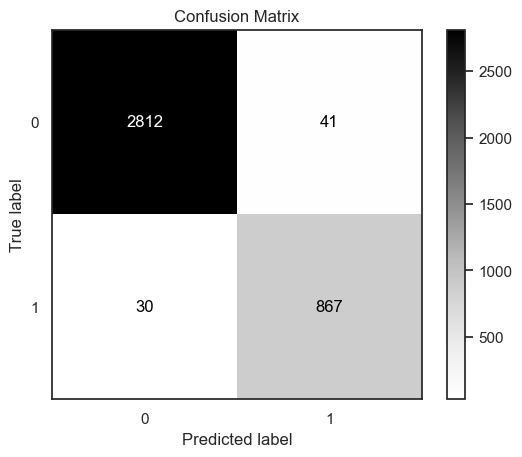

In [73]:
plot_confusion_matriks(y_test, y_tt_lgbm_best)

## Light Gradient Boosting Machine (Light GBM) is the best model ML for this project
model ini menggunakan konsep decision tree atau ensemble dari beberapa decision tree, di mana setiap pohon dibangun secara bertahap untuk meminimalkan kesalahan prediksi. Algoritma ini menggunakan pendekatan yang disebut "leaf-wise growth", di mana pohon dibangun berdasarkan pemilihan fitur yang paling informatif pada setiap langkahnya.

In [76]:
lgbm_best.write.format("pickle").save("hdfs://localhost:9000/user/ASUS/hadoop_clustering_employee_turnover/Resign_LightGBM.pkl")